In [1]:
from google.colab import files
uploaded = files.upload()

Saving d_cardiop_classif.csv to d_cardiop_classif.csv


Avaliando: Exames
Avaliando: MACs
Avaliando: MACs + Exames


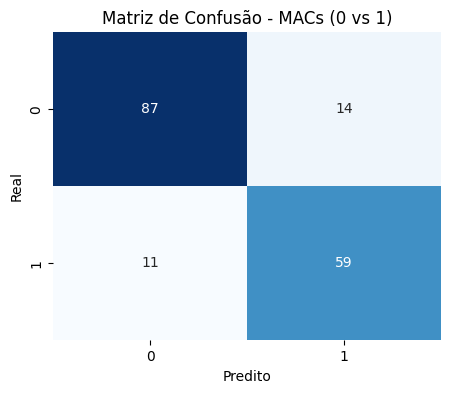

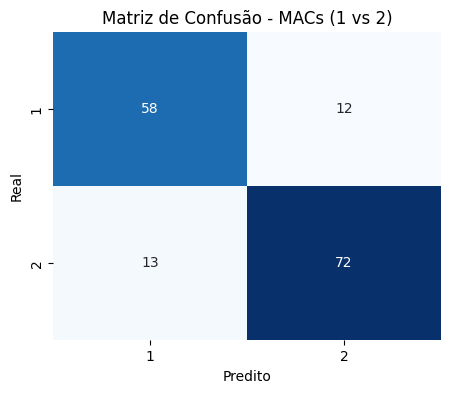

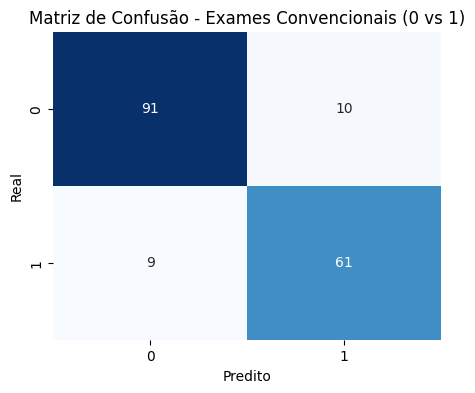

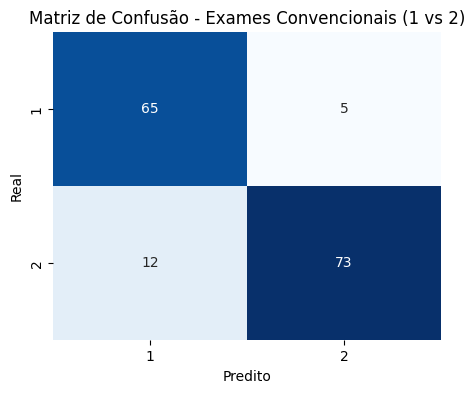

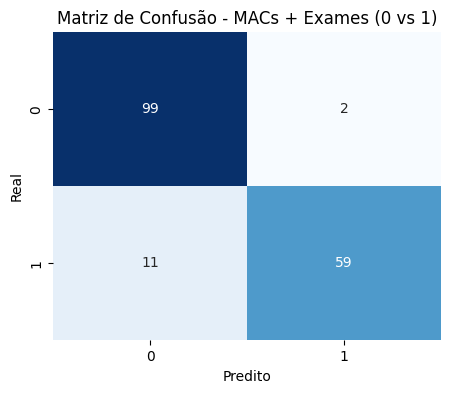

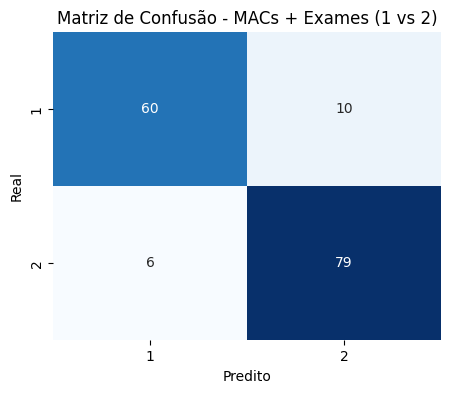

,Modelo,Comparação,Acuracia,Precisao,Recall,F1,AUC
0,MACs,0 vs 1,0.854286,0.811639,0.842857,0.825922,0.908333
1,MACs,1 vs 2,0.838710,0.863471,0.847059,0.849588,0.918067
2,Exames Convencionais,0 vs 1,0.889076,0.877311,0.871429,0.863434,0.957024
3,Exames Convencionais,1 vs 2,0.890323,0.934902,0.858824,0.894675,0.926050
4,MACs + Exames,0 vs 1,0.924202,0.967949,0.842857,0.900855,0.967347
5,MACs + Exames,1 vs 2,0.896774,0.890065,0.929412,0.908435,0.957983


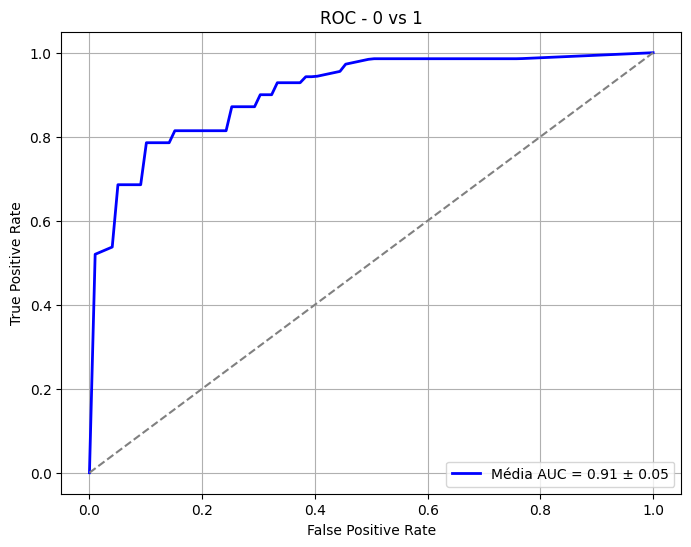

Média AUC: 0.907 ± 0.046


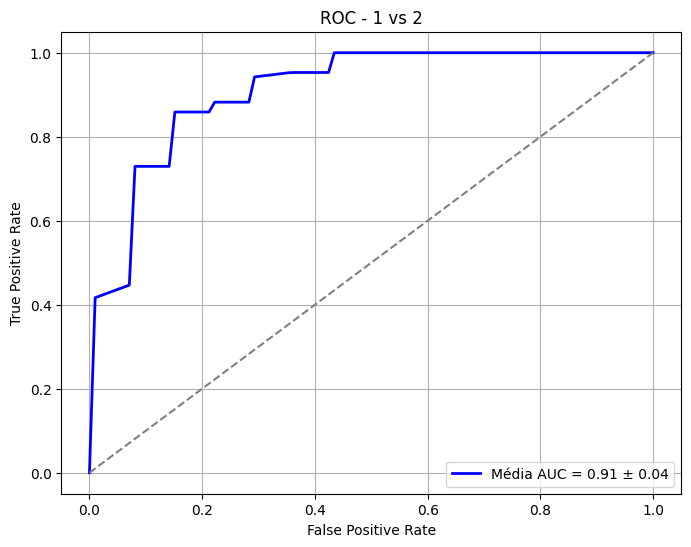

Média AUC: 0.910 ± 0.036


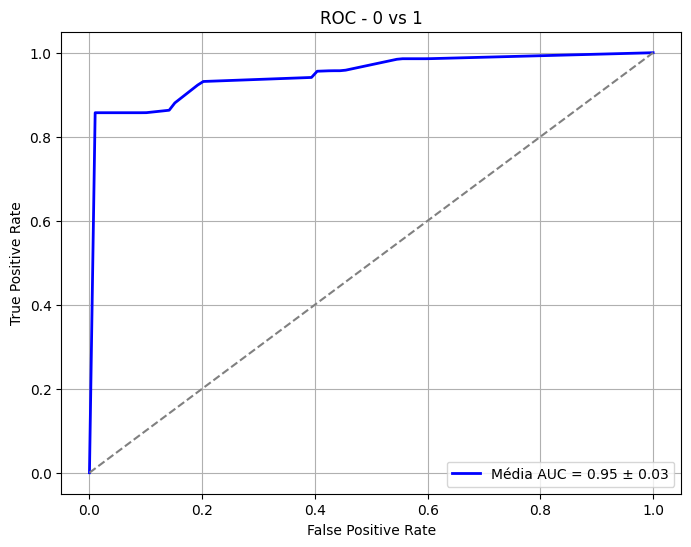

Média AUC: 0.948 ± 0.033


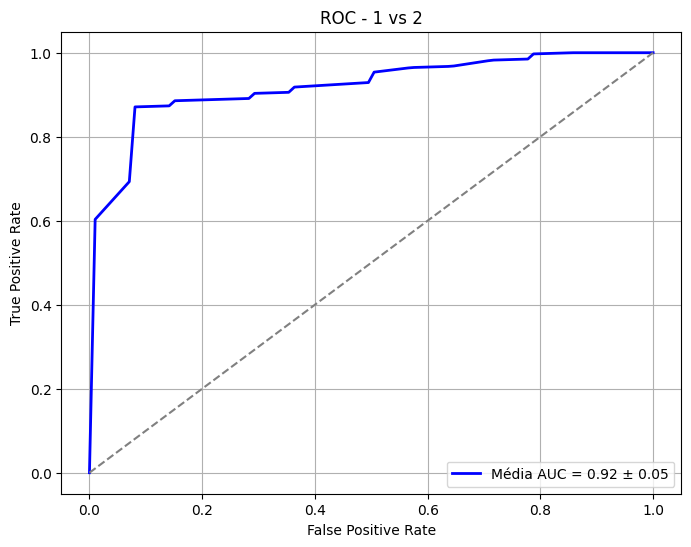

Média AUC: 0.919 ± 0.050


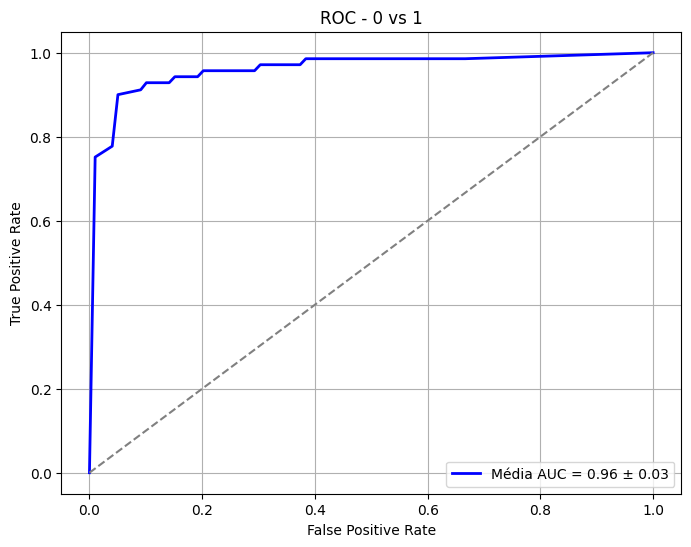

Média AUC: 0.961 ± 0.034


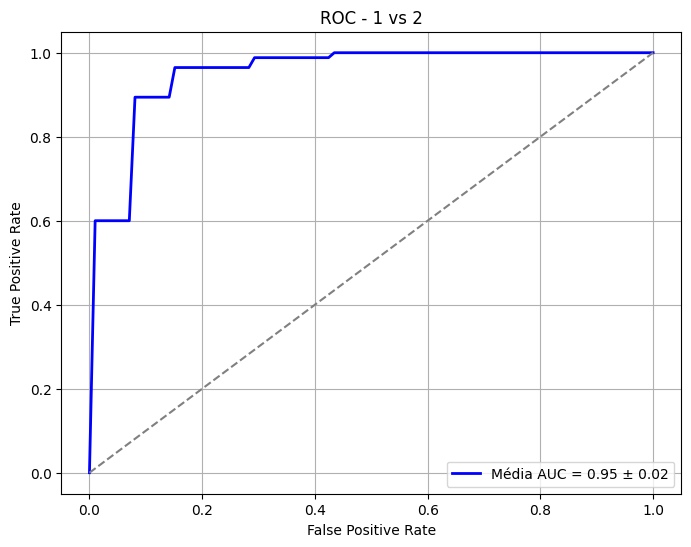

Média AUC: 0.953 ± 0.022


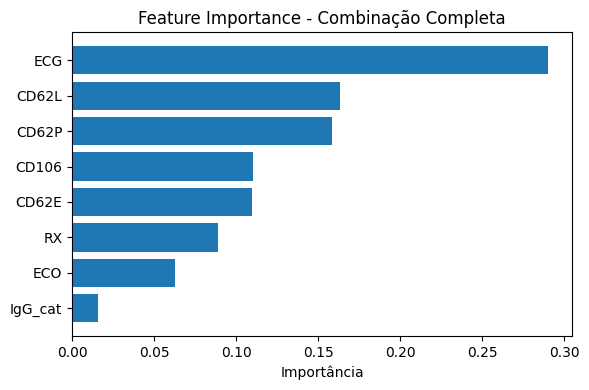

(256, 8, 3)

🔷 Classe: 0


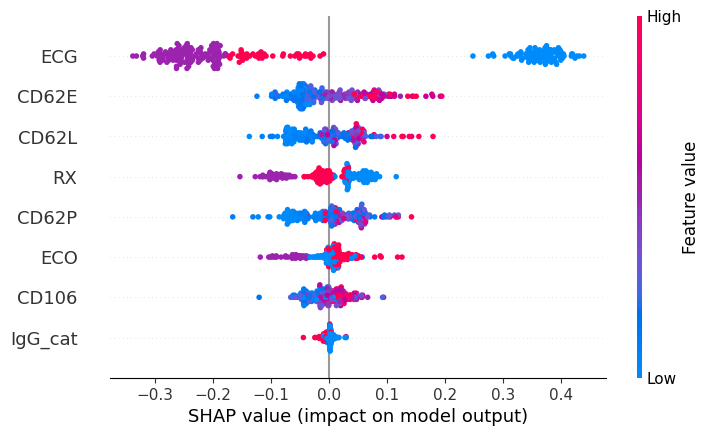


🔷 Classe: 1


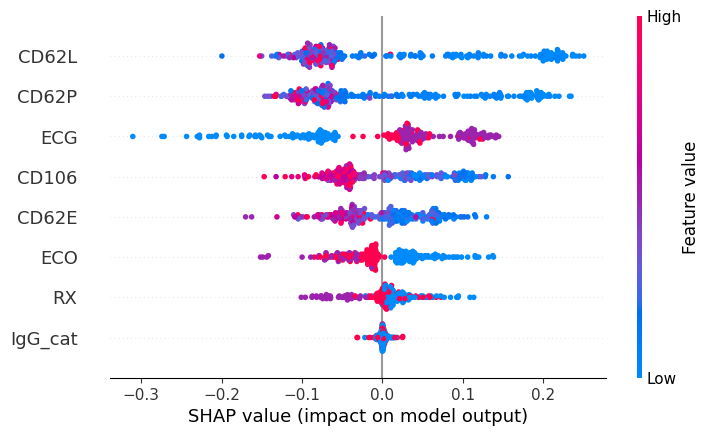


🔷 Classe: 2


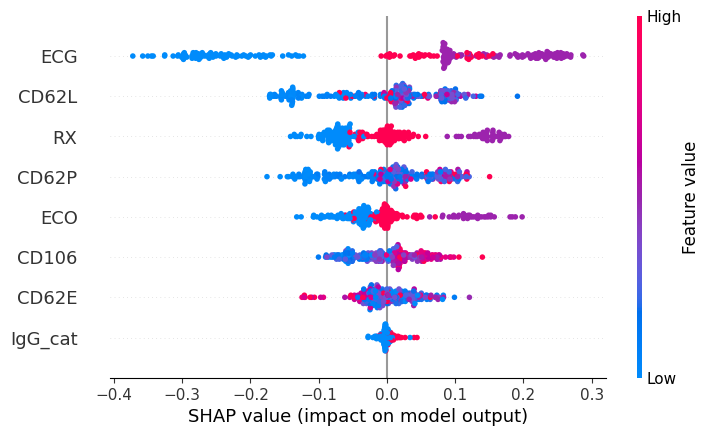

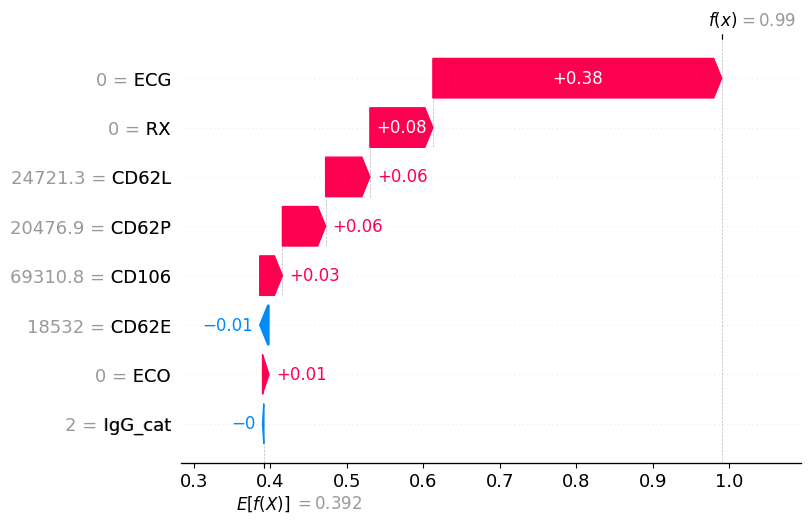

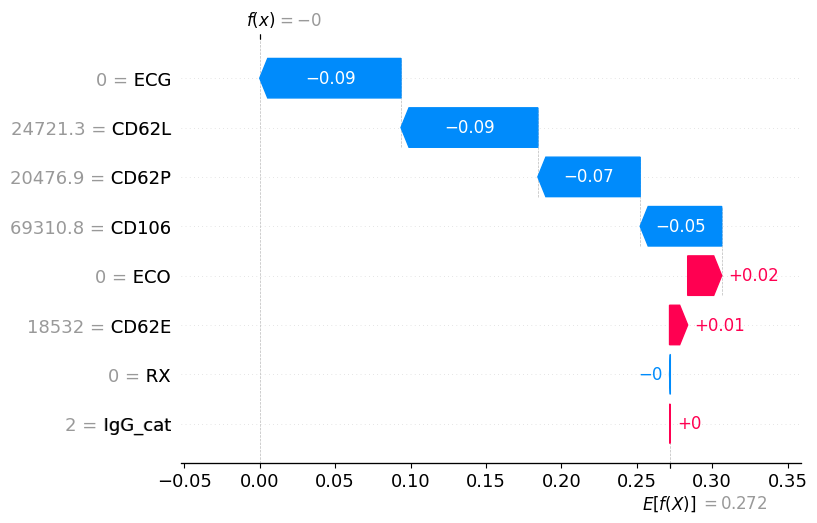

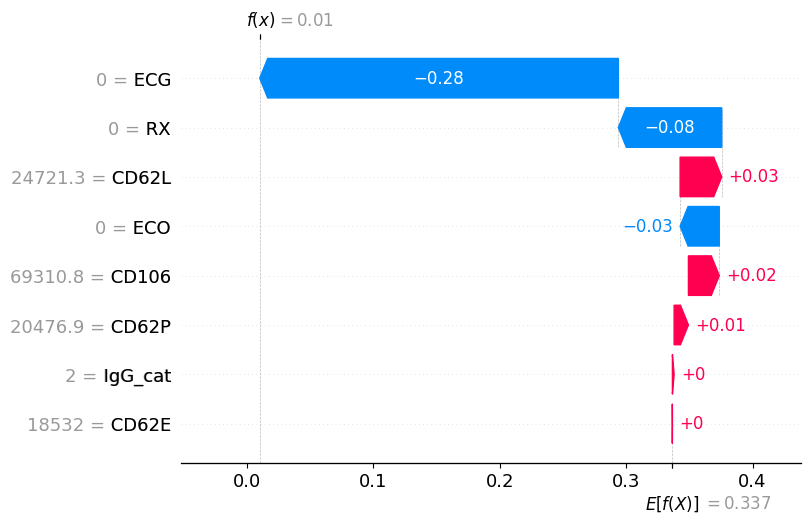

In [9]:
## Bibliotecas ##

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, RocCurveDisplay
from itertools import combinations

## Pré-processamento dos dados ##

df = pd.read_csv('d_cardiop_classif.csv', sep=';')
df = df.replace(',','.',regex=True)

mac_features = ['CD106','CD62P','CD62L','CD62E']
exames_features = ['ECG','RX','ECO','IgG_cat']
idade_feature = ['IDADE']
IgG_num_feature = ['IgG_num']

target = 'CLASSIF'

for col in mac_features:
  df[col] = df[col].astype(float)
for col in idade_feature:
  df[col] = df[col].astype(float)
for col in IgG_num_feature:
  df[col] = df[col].astype(float)

feature_sets = {
    'Exames': exames_features,
    'MACs': mac_features,
    'MACs + Exames': mac_features + exames_features
}

for name, features in feature_sets.items():
    print(f'Avaliando: {name}')


x = df[mac_features + exames_features]
y = df[target]


## Matriz de Confusão + Métricas ##

def confusion_and_metrics_binaria(x, y, class1, class2, features, model_name='Modelo', n_splits=5):

    mask = y.isin([class1, class2])
    x_bin = x.loc[mask, features]
    y_bin = y.loc[mask].map({class1: 0, class2: 1})

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    cm_total = np.array([[0, 0], [0, 0]])
    acc_list = []
    prec_list = []
    recall_list = []
    f1_list = []
    auc_list = []

    for train_index, test_index in skf.split(x_bin, y_bin):
        x_train, x_test = x_bin.iloc[train_index], x_bin.iloc[test_index]
        y_train, y_test = y_bin.iloc[train_index], y_bin.iloc[test_index]

        model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        y_proba = model.predict_proba(x_test)[:, 1]

        cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
        cm_total += cm

        acc_list.append(accuracy_score(y_test, y_pred))
        prec_list.append(precision_score(y_test, y_pred, zero_division=0))
        recall_list.append(recall_score(y_test, y_pred, zero_division=0))
        f1_list.append(f1_score(y_test, y_pred, zero_division=0))
        auc_list.append(roc_auc_score(y_test, y_proba))


    # Plotar matriz de confusão
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_total, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[f'{class1}', f'{class2}'],
                yticklabels=[f'{class1}', f'{class2}'])
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusão - {model_name} ({class1} vs {class2})')
    plt.show()

    # Resultados médios
    results = pd.DataFrame({
        'Modelo': [model_name],
        'Comparação': [f'{class1} vs {class2}'],
        'Acuracia': [np.mean(acc_list)],
        'Precisao': [np.mean(prec_list)],
        'Recall': [np.mean(recall_list)],
        'F1': [np.mean(f1_list)],
        'AUC': [np.mean(auc_list)]
    })

    return results

# Modelo MACs para comparar sem cardiopatia (0) vs leve (1):
resultadomacs_0vs1 = confusion_and_metrics_binaria(
    x= df[mac_features],
    y= df['CLASSIF'],
    class1=0,
    class2=1,
    features= mac_features,
    model_name='MACs',
    n_splits=5
)

# Modelo MACs para comparar leve (1) vs grave (2):
resultadomacs_1vs2 = confusion_and_metrics_binaria(
    x= df[mac_features],
    y= df['CLASSIF'],
    class1=1,
    class2=2,
    features= mac_features,
    model_name='MACs',
    n_splits=5
)


# Modelo Exames para comparar sem cardiopatia (0) vs leve (1):
resultadoexames_0vs1 = confusion_and_metrics_binaria(
    x= df[exames_features],
    y= df['CLASSIF'],
    class1=0,
    class2=1,
    features= exames_features,
    model_name='Exames Convencionais',
    n_splits=5
)

# Modelo Exames para comparar leve (1) vs grave (2):
resultadoexames_1vs2 = confusion_and_metrics_binaria(
    x= df[exames_features],
    y= df['CLASSIF'],
    class1=1,
    class2=2,
    features= exames_features,
    model_name='Exames Convencionais',
    n_splits=5
)

# Modelo Completo para comparar sem cardiopatia (0) vs leve (1):
resultadocompleto_0vs1 = confusion_and_metrics_binaria(
    x= df[mac_features + exames_features],
    y= df['CLASSIF'],
    class1=0,
    class2=1,
    features= mac_features + exames_features,
    model_name='MACs + Exames',
    n_splits=5
)

# Modelo Completo para comparar leve (1) vs grave (2):
resultadocompleto_1vs2 = confusion_and_metrics_binaria(
    x= df[mac_features + exames_features],
    y= df['CLASSIF'],
    class1=1,
    class2=2,
    features= mac_features + exames_features,
    model_name='MACs + Exames',
    n_splits=5
)

# Ver todos os resultados
resultados = pd.concat([resultadomacs_0vs1, resultadomacs_1vs2,
                        resultadoexames_0vs1, resultadoexames_1vs2,
                        resultadocompleto_0vs1, resultadocompleto_1vs2],
                       ignore_index=True)
display(resultados)



## Curva ROC ##

def binary_roc_analysis(x, y, class1, class2, n_splits=5):

    mask = (y == class1) | (y == class2)
    x_filtered = x[mask]
    y_filtered = y[mask]

    y_filtered = y_filtered.map({class1: 0, class2: 1})

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    plt.figure(figsize=(8, 6))

    for train_index, test_index in skf.split(x_filtered, y_filtered):
        x_train, x_test = x_filtered.iloc[train_index], x_filtered.iloc[test_index]
        y_train, y_test = y_filtered.iloc[train_index], y_filtered.iloc[test_index]

        model = RandomForestClassifier(random_state=42)
        model.fit(x_train, y_train)

        y_proba = model.predict_proba(x_test)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    plt.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=f'Média AUC = {mean_auc:.2f} ± {std_auc:.2f}',
        lw=2,
    )

    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC - {class1} vs {class2}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    print(f'Média AUC: {mean_auc:.3f} ± {std_auc:.3f}')

binary_roc_analysis(x=df[mac_features], y=y, class1=0, class2=1)
binary_roc_analysis(x=df[mac_features], y=y, class1=1, class2=2)
binary_roc_analysis(x=df[exames_features], y=y, class1=0, class2=1)
binary_roc_analysis(x=df[exames_features], y=y, class1=1, class2=2)
binary_roc_analysis(x=df[mac_features + exames_features], y=y, class1=0, class2=1)
binary_roc_analysis(x=df[mac_features + exames_features], y=y, class1=1, class2=2)

## Importância das Variáveis ##

def plot_feature_importance(x, y, features, model_name='Modelo'):
  model = RandomForestClassifier(random_state=42)
  model.fit(x[features], y)

  importances = model.feature_importances_
  indices = np.argsort(importances)

  plt.figure(figsize=(6,4))
  plt.title(f'Feature Importance - {model_name}')
  plt.barh(range(len(indices)), importances[indices], align='center')
  plt.yticks(range(len(indices)), [features[i] for i in indices])
  plt.xlabel('Importância')
  plt.tight_layout()
  plt.show()

  return pd.DataFrame({'Feature': [features[i] for i in indices],
                         'Importance': importances[indices]})

plot_feature_importance(df, y, mac_features + exames_features, model_name='Combinação Completa')

# Análise de SHAP value ##

features_total = mac_features + exames_features
model = RandomForestClassifier(random_state=42)
model.fit(x[features_total], y)

# Cria o explainer
explainer = shap.TreeExplainer(model)

# Calcula os SHAP values
shap_values = explainer(x)

# Verifica a forma dos shap_values
print(shap_values.values.shape)  # (n_amostras, n_features, n_classes)

# Loop para cada classe
for i, class_name in enumerate(model.classes_):
    print(f"\n🔷 Classe: {class_name}")
    shap.plots.beeswarm(shap_values[:, :, i])

shap.plots.waterfall(shap_values[87, :, 0])  # Paciente , classe
shap.plots.waterfall(shap_values[87, :, 1])  # Paciente , classe
shap.plots.waterfall(shap_values[87, :, 2])  # Paciente , classe
